In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# 2nd Order Runge-Kutta / Midpoint Method

We'll continue to work on the orbit problem, so let's define our RHS.

In [18]:
G = 4*np.pi**2
M_sun = 1.0

def rhs(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy
    
    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([xdot, ydot, vxdot, vydot])

We'll also define our `OrbitHistory` class again, this time adding a method to return the error we explored previously, and to mae a plot.

In [29]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])
        
    def error_radius(self):
        """return the difference in the distance from the Sun"""
        R_orig = np.sqrt(self.x[0]**2 + self.y[0]**2)
        R_new = np.sqrt(self.x[-1]**2 + self.y[-1]**2)
        return np.abs(R_new - R_orig)        

    def error_position(self):
        """return the difference in the distance from the Sun"""
        dx = self.x[0] - self.x[-1]
        dy = self.y[0] - self.y[-1]
        return np.sqrt(dx**2 + dy**2)

    def plot(self, ax=None, label=None):
        """make a plot of the solution.  If ax is None we setup a figure
        and make the entire plot returning the figure object, otherwise, we
        just append the plot to a current axis"""

        fig = None
        
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)

            # draw the Sun
            ax.scatter([0], [0], marker=(20,1), color="y", s=250)

        # draw the orbit
        ax.plot(self.x, self.y, label=label)

        if fig is not None:
            ax.set_aspect("equal")
            ax.set_xlabel("x [AU]")
            ax.set_ylabel("y [AU]")
            
            return fig, ax

The Euler method was based on a first-order difference approximation to the derivative.  But we know that a centered-derivative is second order accurate, so we can try to update our system in the form:

$$\frac{{\bf r}^{n+1} - {\bf r}^n}{\tau} = {\bf v}^{n+1/2} + \mathcal{O}(\tau^2)$$

$$\frac{{\bf v}^{n+1} - {\bf v}^n}{\tau} = {\bf a}^{n+1/2} + \mathcal{O}(\tau^2)$$

Then the updates are:

$${\bf r}^{n+1} = {\bf r}^n + \tau \, {\bf v}^{n+1/2} + \mathcal{O}(\tau^3)$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}^{n+1/2} + \mathcal{O}(\tau^3)$$

This is locally third-order accurate (but globally second-order accurate), but we don't know how to compute the state at the half-time.

To find the $n+1/2$ state, we first use Euler's method to predict the state at the midpoint in time.  We then use this provisional state to evaluate the accelerations at the midpoint and use those to update the state fully through $\tau$.  

The two step process appears as:

$${\bf r}^\star = {\bf r}^n + (\tau / 2) {\bf v}^n$$

$${\bf v}^\star = {\bf v}^n + (\tau / 2) {\bf a}^n$$

then we use this for the full update:

$${\bf r}^{n+1} = {\bf r}^n + \tau \,  {\bf v}^\star$$

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}({\bf r}^\star)$$

Graphically this looks like the following:

First we take a half step and we evaluate the slope at the midpoint:

![RK2 half step](rk2_halfEuler.png)

Then we go back to $t^n$ but follow the slope we found above all the way to $t^{n+1}$:

![RK2 final](rk2_final.png)

Notice how the final step (the red line) is parallel to the slope we computed at $t^{n+1/2}$.  Also note that the solution at $t^{n+1}$ is much closer to the analytic solution than in the figure from Euler's method.

Let's see how this method does with the orbit problem.

In [30]:
def euler_rk2(Y0, tau, T):

    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Ydot = rhs(t, Y)
    
        # predict the state at the midpoint
        Ytmp = Y + 0.5 * tau * Ydot
        
        # evaluate the RHS at the midpoint
        Ydot = rhs(t + 0.5*tau, Ytmp)
        
        # do the final update
        Y += tau * Ydot
        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
 

Setup our initial conditions as before with Earth on the +y axis and a counterclockwise circular velocity.

In [38]:
def initial_conditions():
    x0 = 0
    y0 = 1
    vx0 = -np.sqrt(G*M_sun/y0)
    vy0 = 0

    return np.array([x0, y0, vx0, vy0])

Integrate our orbit.

In [39]:
T = 1
tau = T/12.0

Y0 = initial_conditions()

orbit = euler_rk2(Y0, tau, 1)

Let's plot our orbit

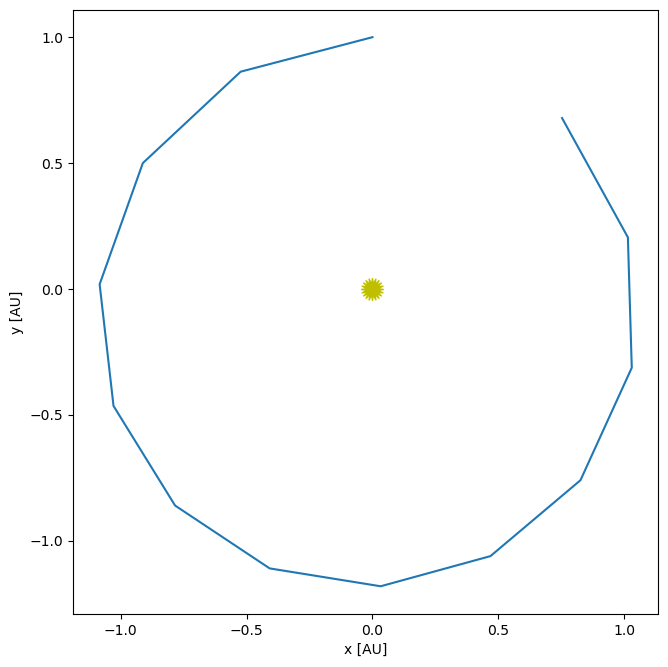

In [40]:
fig = orbit.plot()

This is substantially better than the first-order Euler method.  Now let's look at a range of timesteps.

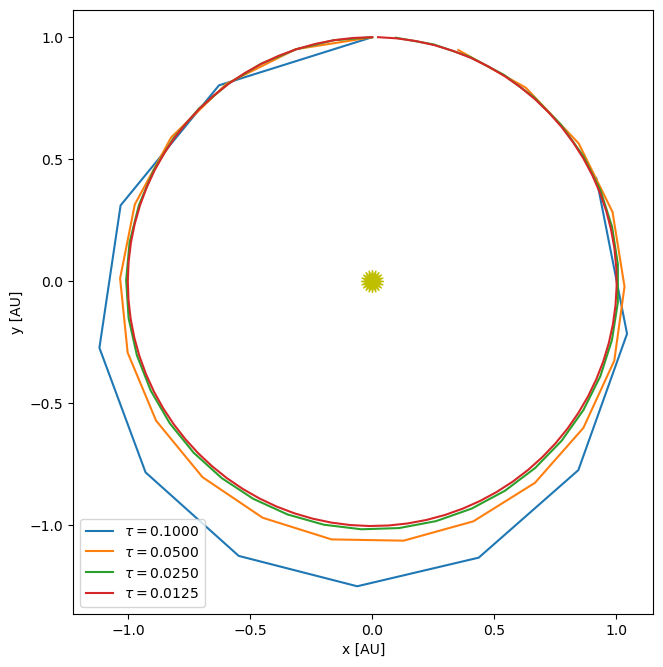

In [36]:
taus = [0.1, 0.05, 0.025, 0.0125]

for n, tau in enumerate(taus):
    orbit = euler_rk2(Y0, tau, 1)
    
    if n == 0:
        fig, ax = orbit.plot(label=rf"$\tau = {tau:6.4f}$")
    else:
        orbit.plot(ax=ax, label=rf"$\tau = {tau:6.4f}$")
        
ax.legend()

and how does the error converge?

In [37]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
    o = euler_rk2(Y0, tau, 1)
    print(f"tau = {tau:8.5f}, error = {o.error_radius():10.5g} {o.error_position():10.5g}")

tau =  0.10000, error =     0.0116     1.0856
tau =  0.05000, error =   0.011123    0.35694
tau =  0.02500, error =  0.0024709   0.096669
tau =  0.01250, error = 0.00036069   0.023906
tau =  0.00625, error = 4.6926e-05  0.0058463


Notice that once we get past the first, very coarse $\tau$, the errors seem to decrease by a factor of 4 when we halve the timestep&mdash;as we'd expect for a 2nd order accurate method. (Actually, it looks like the measure of radius converges better than position).